# EDA & Data Preprocessing

This notebook details the exploratory data analysis (EDA) of the Vodafone_Customer_Churn_Sample_Dataset.csv. The analysis covers handling null values, assessing class balance, and evaluating both numerical and categorical variables, culminating in a correlation analysis.

### 1. Loading and Initial Inspection

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset
df = pd.read_csv('..\\data\\Vodafone_Customer_Churn_Sample_Dataset.csv')

# Display the first few rows
print("First 5 Rows:")
df.head()

First 5 Rows:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
# Get a concise summary of the dataframe
print("\nDataframe Info:")
df.info()


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 no

### 2. Data Cleaning and Preparation

In [3]:
# Convert TotalCharges to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for rows where TotalCharges is now NaN
# These are the 11 customers with 0 tenure
print("Customers with missing TotalCharges:")
print(df[df['TotalCharges'].isnull()][['tenure', 'TotalCharges']])

# Impute missing values. Since tenure is 0, their total charges are also 0.
df['TotalCharges'].fillna(0, inplace=True)

# Drop the customerID column
df.drop('customerID', axis=1, inplace=True)

# Convert the target variable 'Churn' to a binary 0/1 format
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

Customers with missing TotalCharges:
      tenure  TotalCharges
488        0           NaN
753        0           NaN
936        0           NaN
1082       0           NaN
1340       0           NaN
3331       0           NaN
3826       0           NaN
4380       0           NaN
5218       0           NaN
6670       0           NaN
6754       0           NaN


C:\Users\esteb\AppData\Local\Temp\ipykernel_13472\3895220236.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


### 3. Target Variable Analysis: Class Imbalance

In [4]:
# Create a custom palette
no_churn_colour = '#ACAEBA'
churn_colour = '#F00120'
churn_palette = {1: churn_colour, 0: no_churn_colour}

Churn Distribution:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


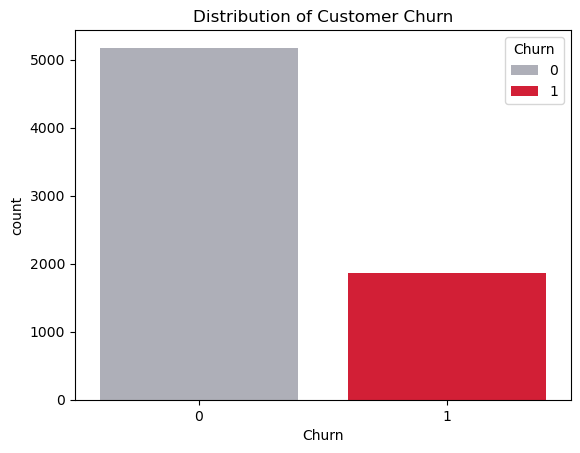

In [5]:
# Calculate churn percentage
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print(f"Churn Distribution:\n{churn_percentage}")

# Visualize it
sns.countplot(x='Churn', data=df, hue='Churn', palette=churn_palette)
plt.title('Distribution of Customer Churn')
plt.show()

We have a significant class imbalance. Approximately 73% of customers did not churn, while only 27% did. This is a crucial finding. A naive model could achieve 73% accuracy by simply predicting "No Churn" every time. Therefore, we must use evaluation metrics like AUC-ROC and F1-Score and consider techniques like class weighting in our model.

### 4. Exploratory Data Analysis

Function Definition

In [6]:
# Numerical Analysis Function
def vis_num_distribution(dataset: pd.DataFrame, column_name: str):
    """
    Visualizes the distribution of a numerical column, split by the "Churn" column.

    Generates a histogram, a split boxplot, and an overall boxplot to provide a comprehensive view
    of the numerical column's distribution.

    Args:
        dataset: The Pandas DataFrame containing the data.
        column_name: The name of the numerical column to visualize.

    Returns:
        None. Displays the plots.
    """

    print("Visualizing distribution for:", column_name)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Histogram split by Churn with KDE
    sns.histplot(data=dataset, x=column_name, hue="Churn", bins=20, ax=axes[0], kde=True, palette=churn_palette)
    kde_line = axes[0].lines[1] 
    kde_line.set_color(no_churn_colour)
    kde_line.set_linewidth(2)
    kde_line_2 = axes[0].lines[0]
    kde_line_2.set_color(churn_colour)
    kde_line_2.set_linewidth(2)
    axes[0].set_title(f'Histogram of {column_name} by Churn')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')


    # Boxplot split by Churn
    # ---- FIX is here: Removed hue='Churn' ----
    sns.boxplot(x=dataset[column_name], hue=dataset["Churn"], ax=axes[1], palette=churn_palette, legend=False)
    axes[1].set_title(f'Boxplot of {column_name} by Churn')
    # ---- FIX is here: Swapped axis labels ----
    axes[1].set_ylabel('Churn')
    axes[1].set_xlabel(column_name)

    # Overall Boxplot
    sns.boxplot(x=dataset[column_name], ax=axes[2], color=no_churn_colour)
    axes[2].set_title(f'Overall Boxplot of {column_name}')
    axes[2].set_xlabel(column_name)

    plt.tight_layout()
    plt.show()


def plot_categorical_distribution(df: pd.DataFrame, 
                              category_col: str, 
                              target_col: str = 'Churn'):
    """
    Visualizes a categorical column's distribution against the 'Churn' target variable,
    replicating the style of the provided image.

    Generates two side-by-side plots:
    1. A side-by-side bar chart showing absolute counts.
    2. A 100% stacked horizontal bar chart showing percentages.

    Args:
        df: The Pandas DataFrame containing the data.
        category_col: The name of the main categorical column to plot on the axis.
        target_col: The name of the target/hue column (must contain 0s and 1s).
    """
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # --- Plot 1: Side-by-Side Bar Chart (Absolute Counts) ---
    ax1 = sns.countplot(data=df, x=category_col, hue=target_col, palette=churn_palette, ax=axes[0])

    ax1.set_title(f'Count of {target_col} by {category_col}', fontsize=14)
    ax1.set_xlabel(category_col, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # Add count labels on top of the bars
    for p in ax1.patches:
        height = p.get_height()
        if height > 0:
            ax1.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                         ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=11)

    ax1.legend(title=target_col)

    # --- Plot 2: 100% Stacked Bar Chart (Percentages) ---
    # Calculate the percentage for each category
    counts_df = df.groupby([category_col, target_col]).size().unstack(fill_value=0)
    percents_df = counts_df.div(counts_df.sum(axis=1), axis=0)
    
    # Use the same category order as the first plot
    category_order = df[category_col].value_counts().index
    percents_df = percents_df.reindex(category_order)
    # Plot the horizontal stacked bar chart
    ax2 = percents_df.plot(kind='barh', stacked=True, 
                           color=churn_palette, 
                           ax=axes[1])

    ax2.set_title(f'Percentage of {target_col} by {category_col}', fontsize=14)
    ax2.set_xlabel('Percentage', fontsize=12)
    ax2.set_ylabel(category_col, fontsize=12)
    ax2.set_xlim(0, 1)

    # Add percentage labels in the center of the bars
    for container in ax2.containers:
        labels = [f'{v * 100:.1f}%' if v > 0 else '' for v in container.datavalues]
        ax2.bar_label(container, labels=labels, label_type='center', color='white', weight='bold', fontsize=11)

    ax2.legend(title=target_col, bbox_to_anchor=(1.01, 1), loc='upper left')

    # Adjust layout and show the plot
    plt.tight_layout(rect=[0, 0, 0.95, 1]) # Adjust rect to make space for the legend
    plt.show()

Numerical Columns Analysis

In [7]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304,0.265370
std,0.368612,24.559481,30.090047,2266.794470,0.441561
min,0.000000,0.000000,18.250000,0.000000,0.000000
25%,0.000000,9.000000,35.500000,398.550000,0.000000
50%,0.000000,29.000000,70.350000,1394.550000,0.000000
75%,0.000000,55.000000,89.850000,3786.600000,1.000000
max,1.000000,72.000000,118.750000,8684.800000,1.000000


Visualizing distribution for: SeniorCitizen


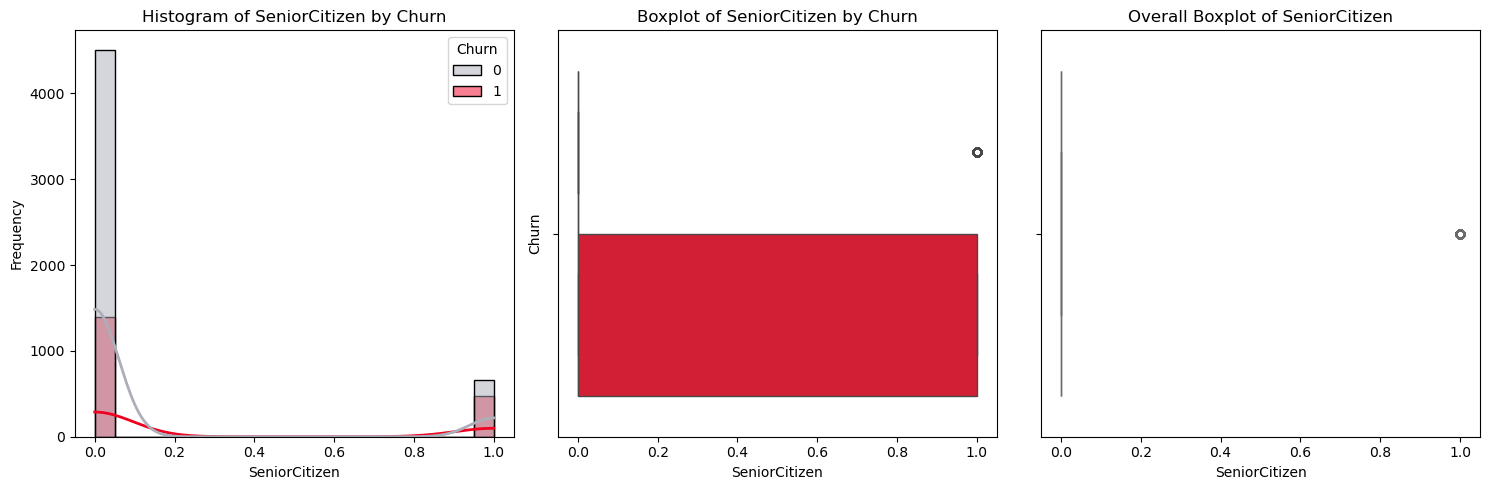

Visualizing distribution for: tenure


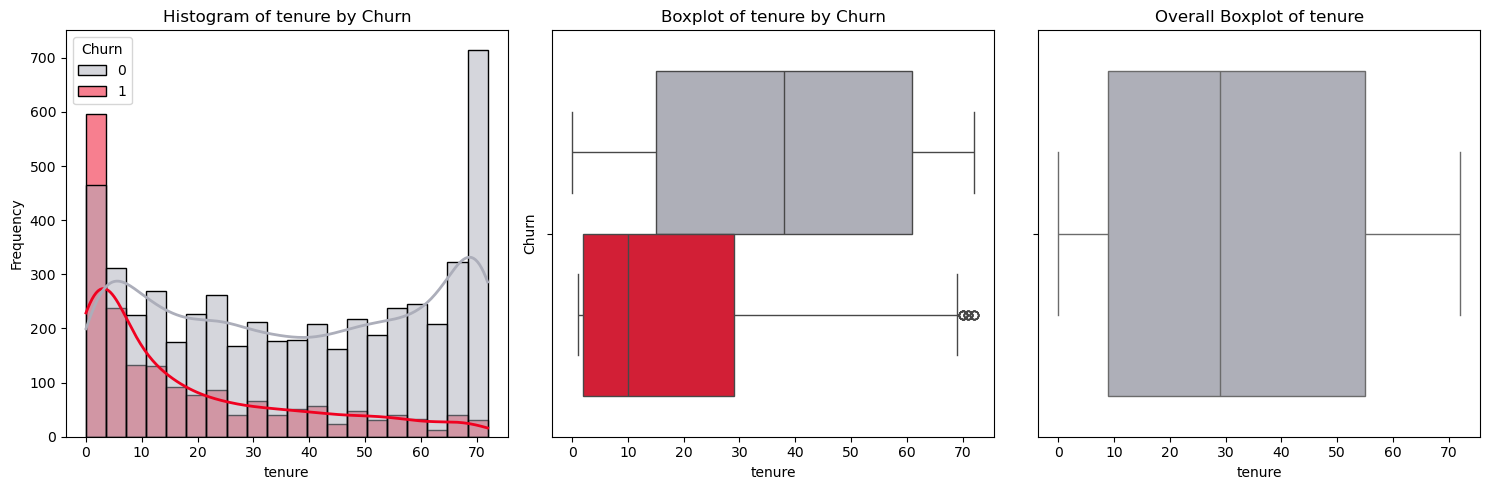

Visualizing distribution for: MonthlyCharges


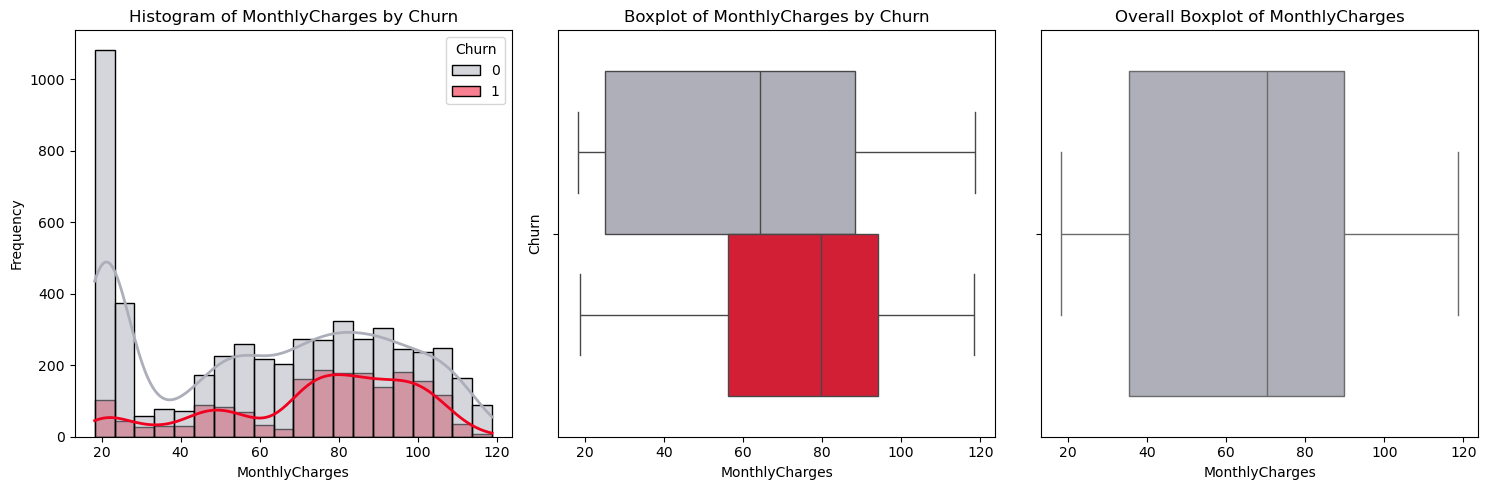

Visualizing distribution for: TotalCharges


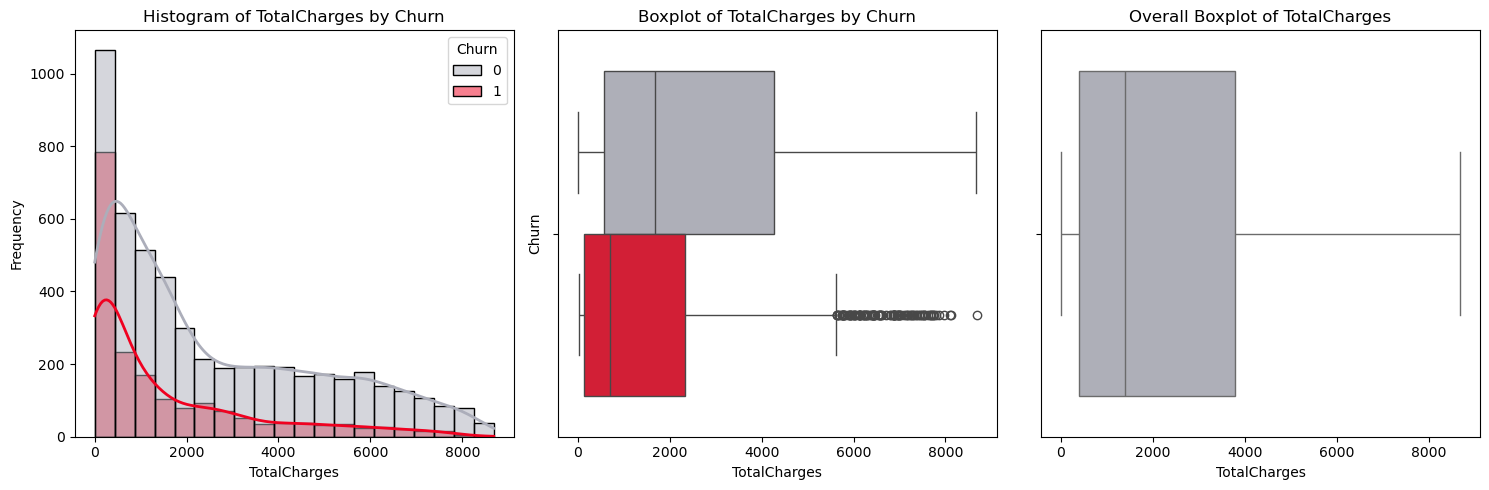

In [7]:
# Identify all numerical columns except the target variable 'Churn'
num_cols = df.select_dtypes(include=[np.number]).columns.drop('Churn')

# Apply vis_num_distribution to each numerical column
for col in num_cols:
    vis_num_distribution(df, col)

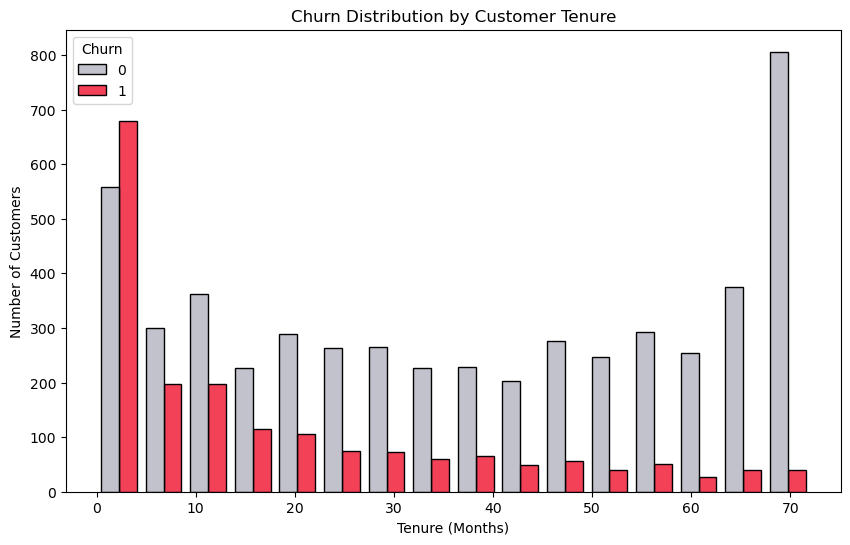

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='dodge', shrink=.8, palette=churn_palette)
plt.title('Churn Distribution by Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()

- Customers with higher monthly costs are more likely to churn.
- A large number of customers churn within the first few months. As tenure increases, churn drops significantly, indicating that long-term customers are more loyal.

Categorical Columns Analysis

Categorical Variable: gender


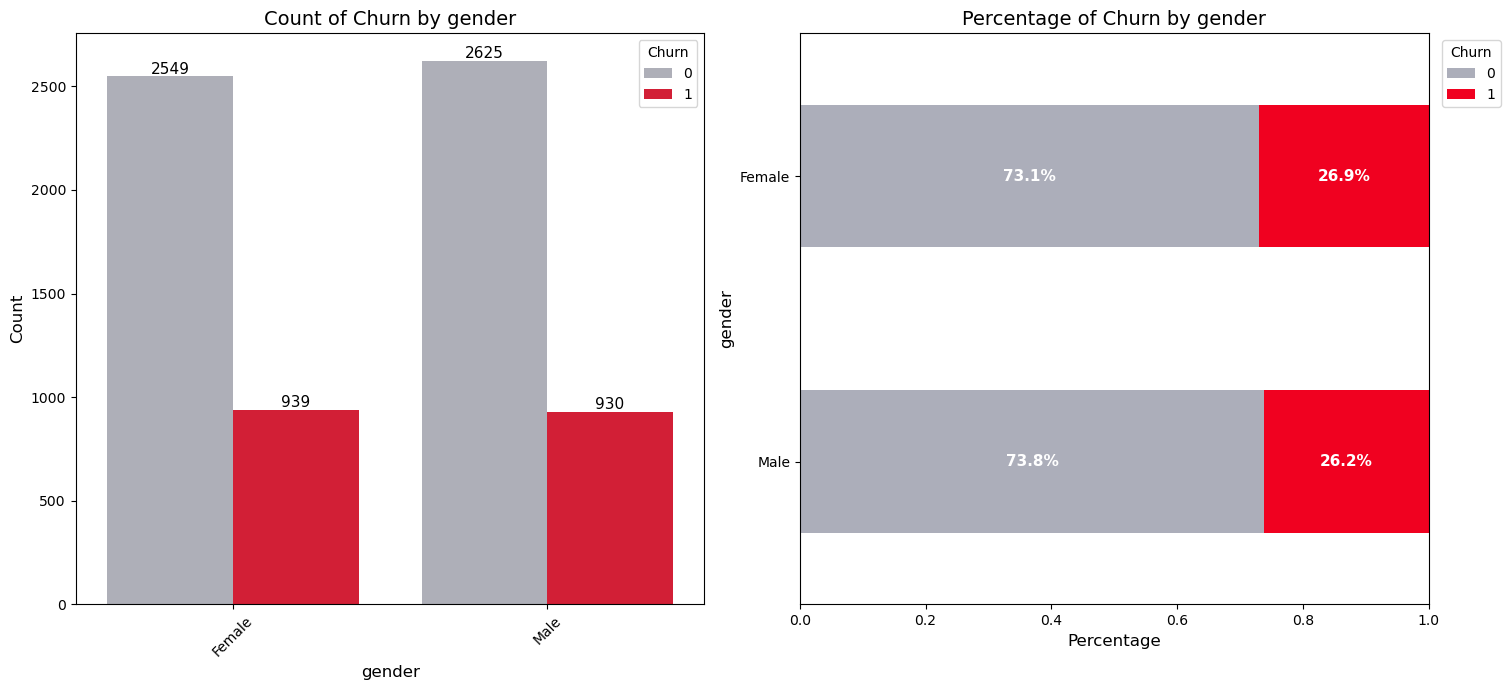

Categorical Variable: Partner


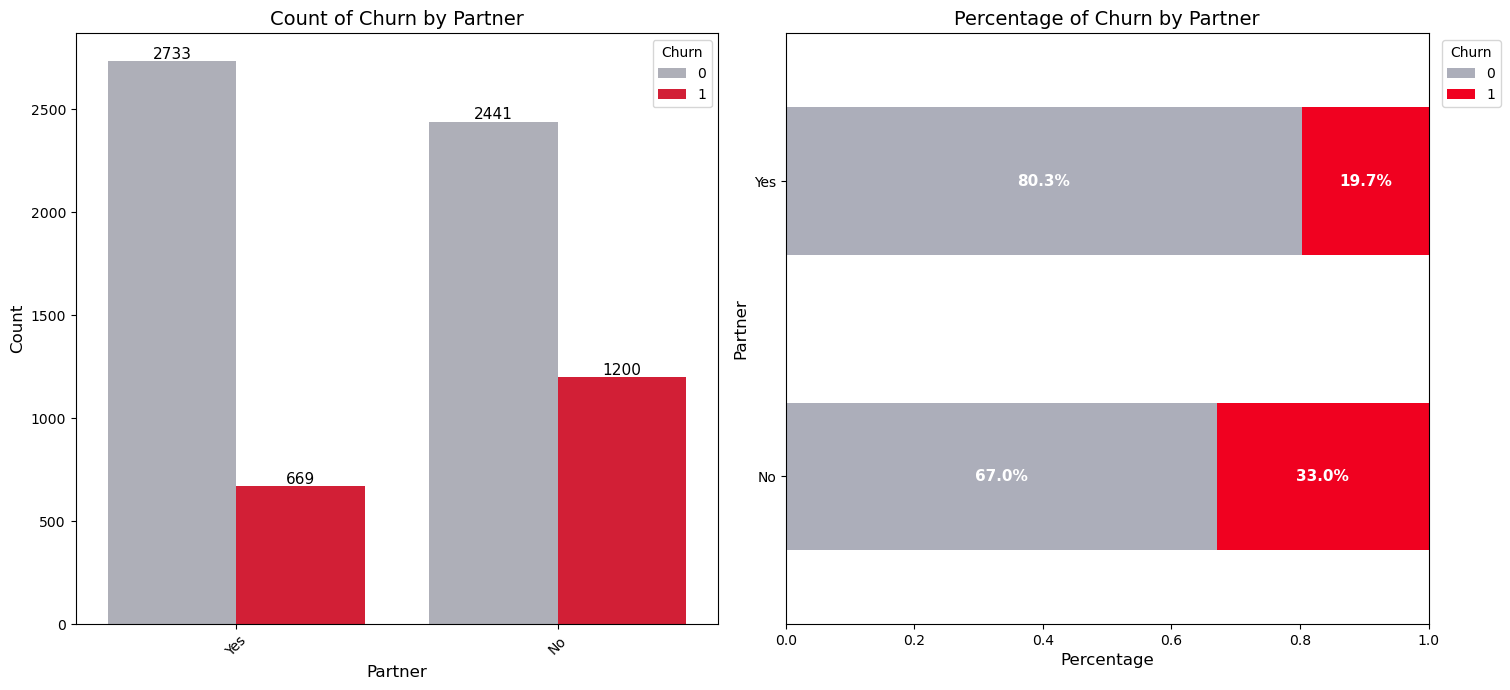

Categorical Variable: Dependents


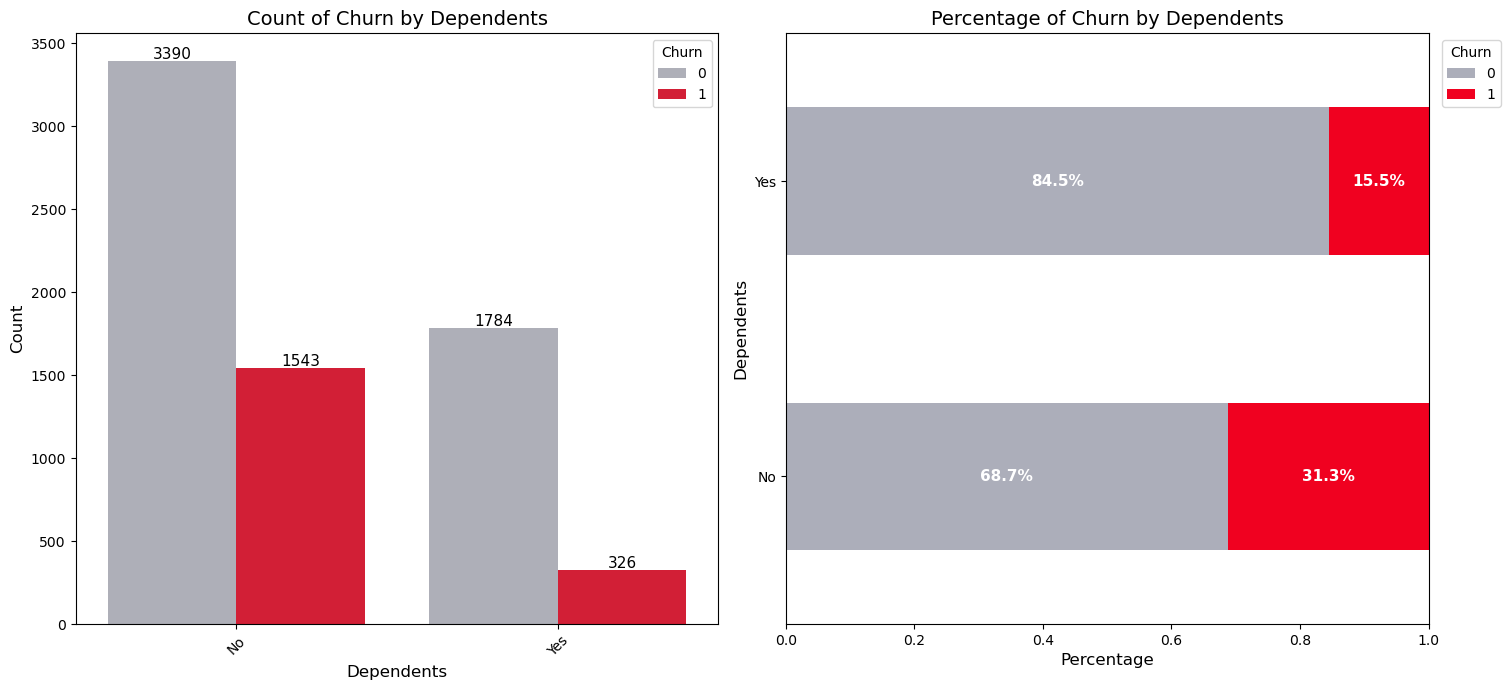

Categorical Variable: PhoneService


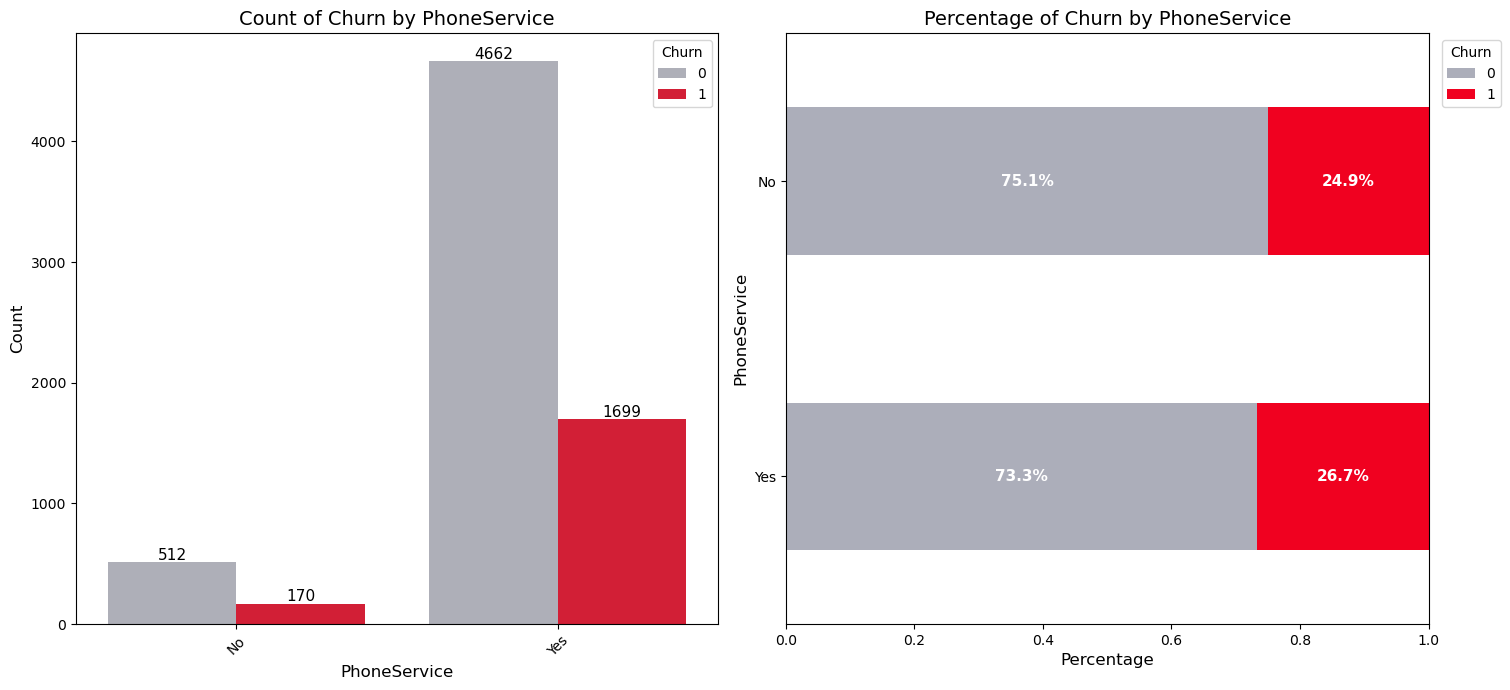

Categorical Variable: MultipleLines


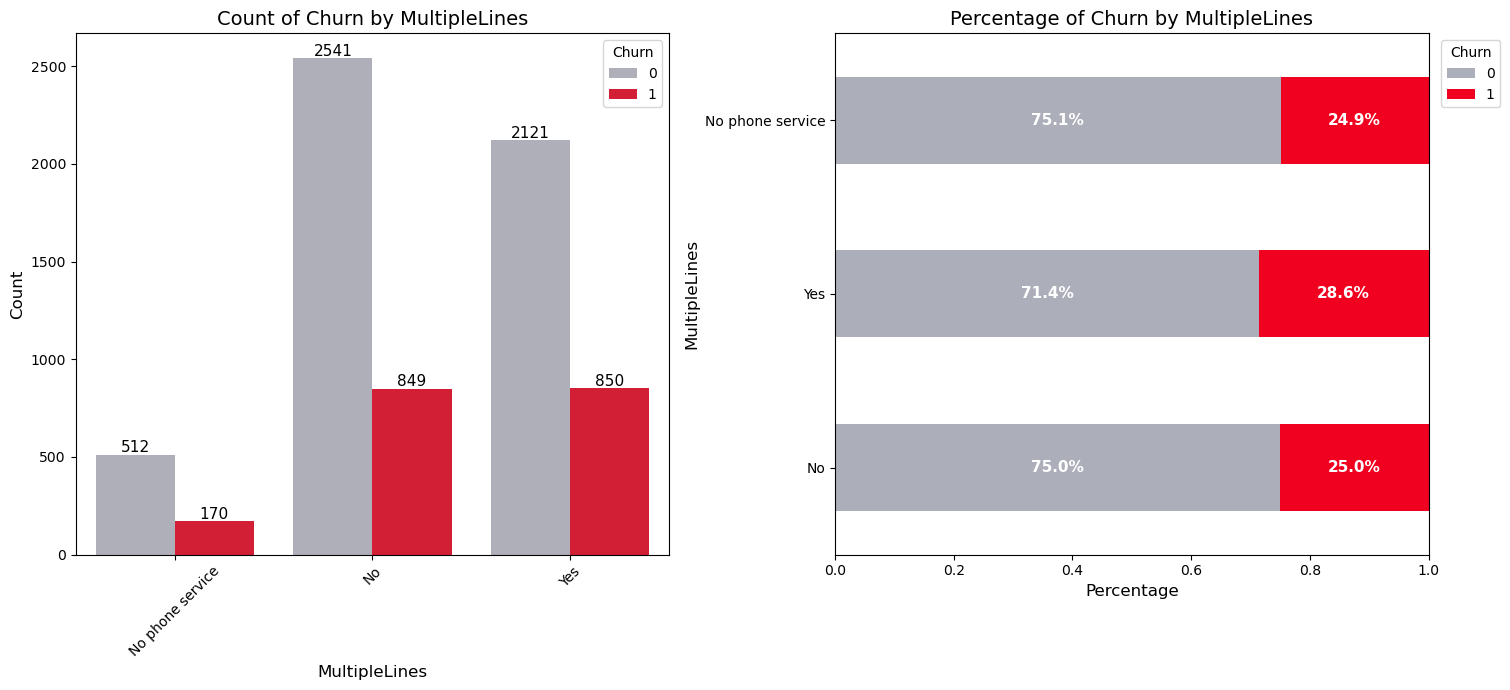

Categorical Variable: InternetService


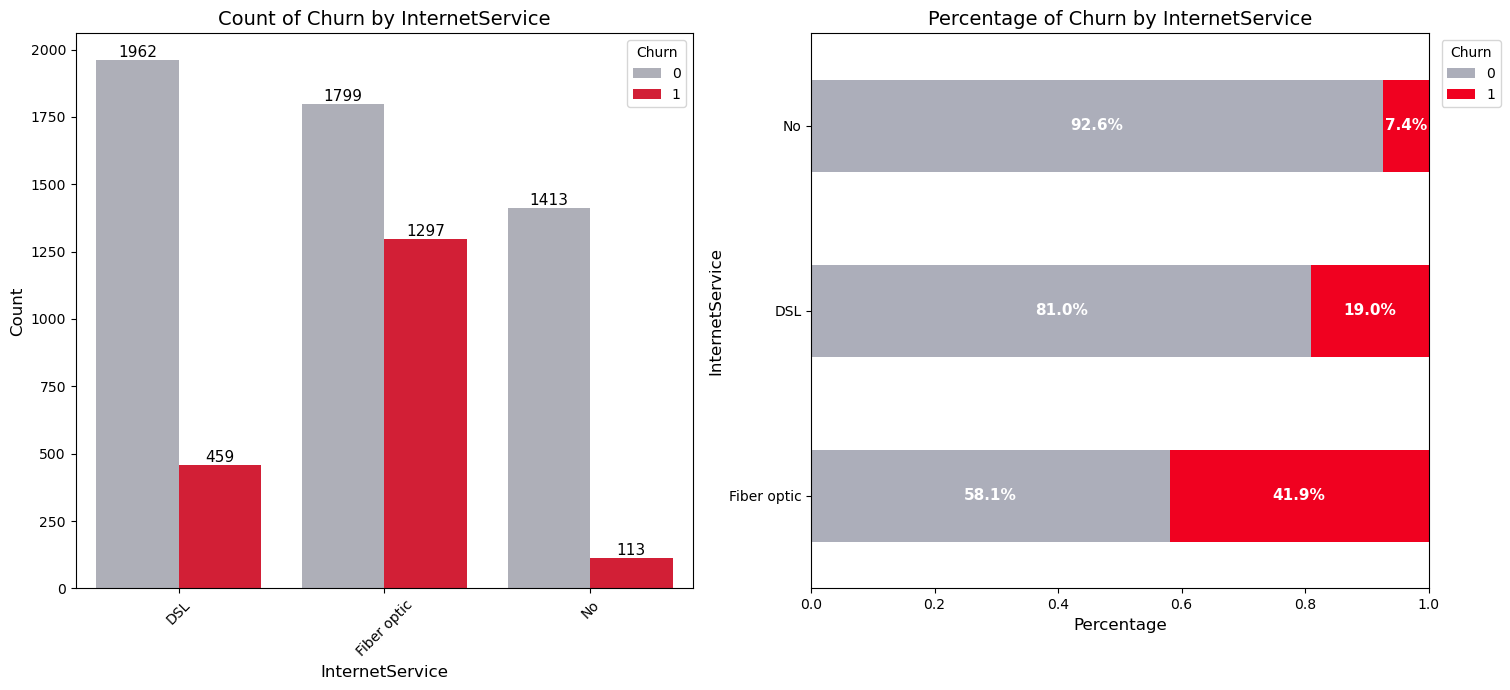

Categorical Variable: OnlineSecurity


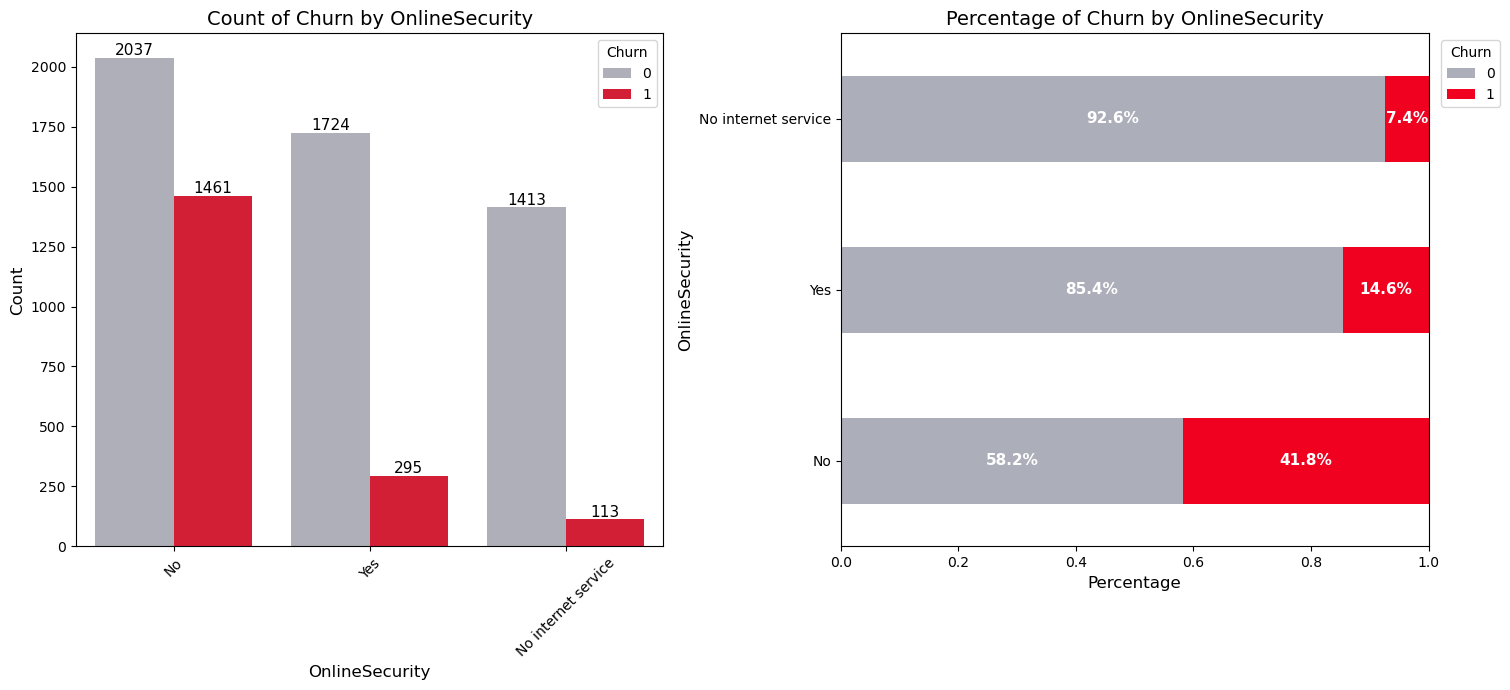

Categorical Variable: OnlineBackup


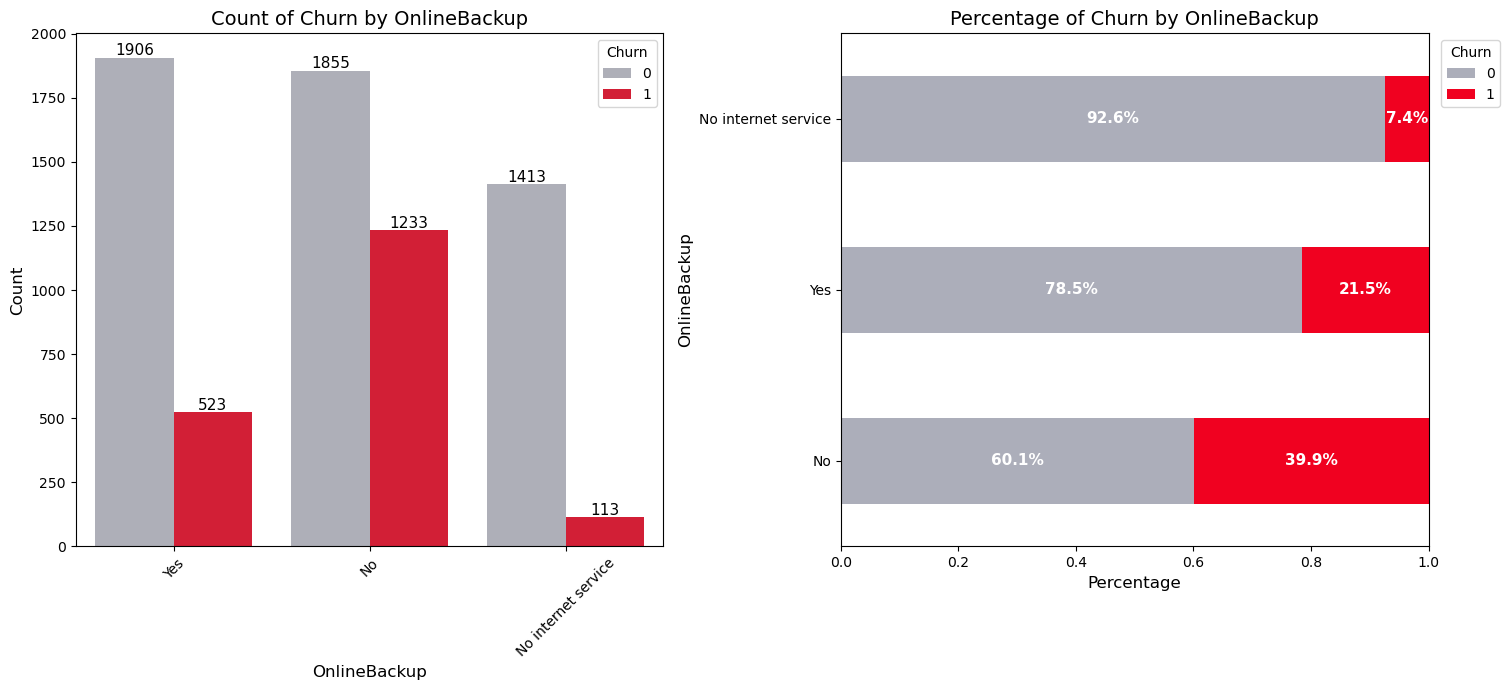

Categorical Variable: DeviceProtection


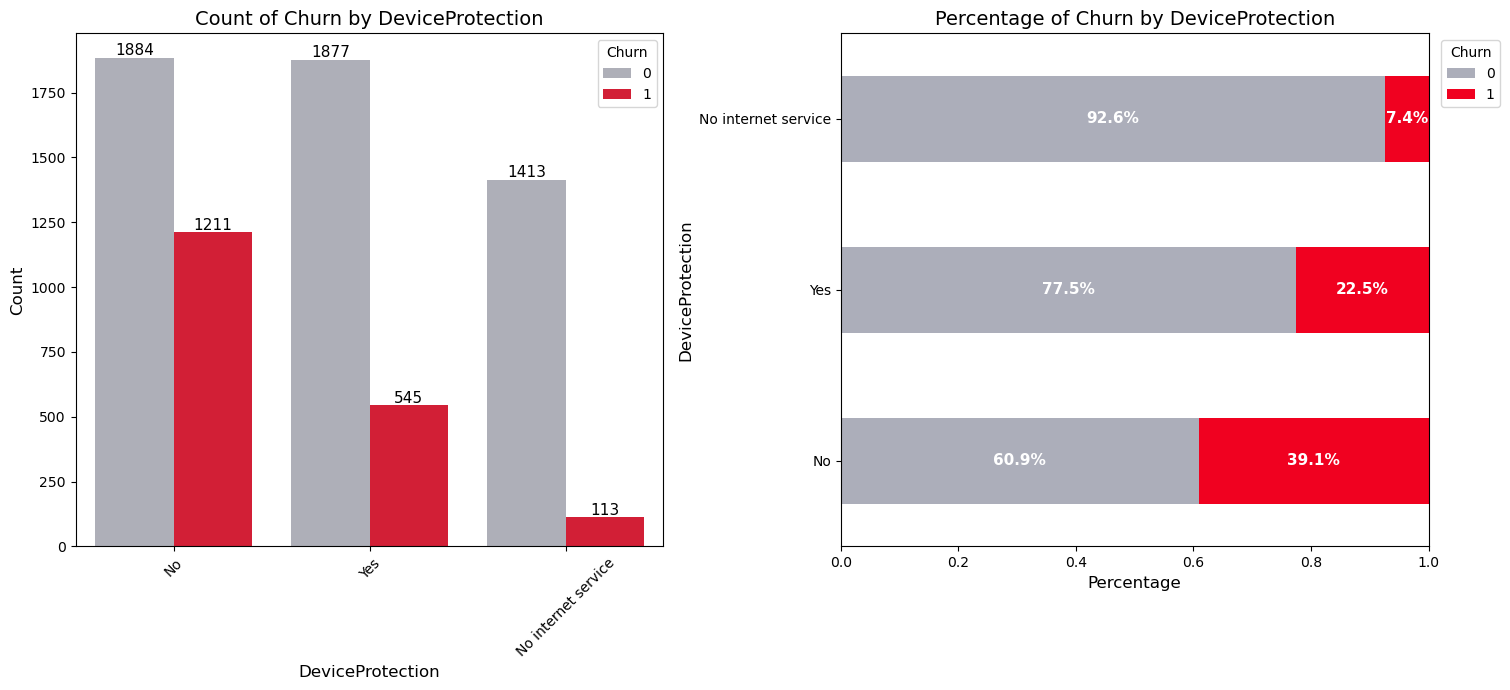

Categorical Variable: TechSupport


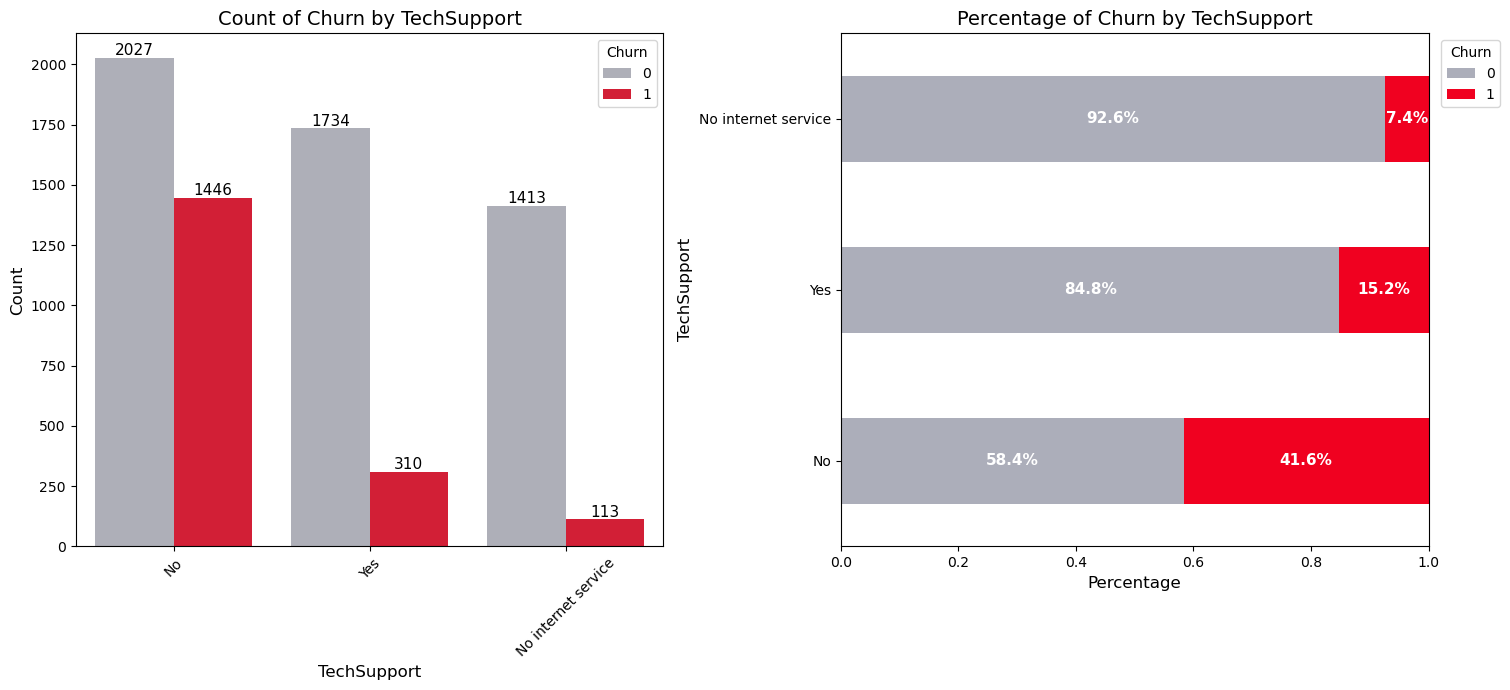

Categorical Variable: StreamingTV


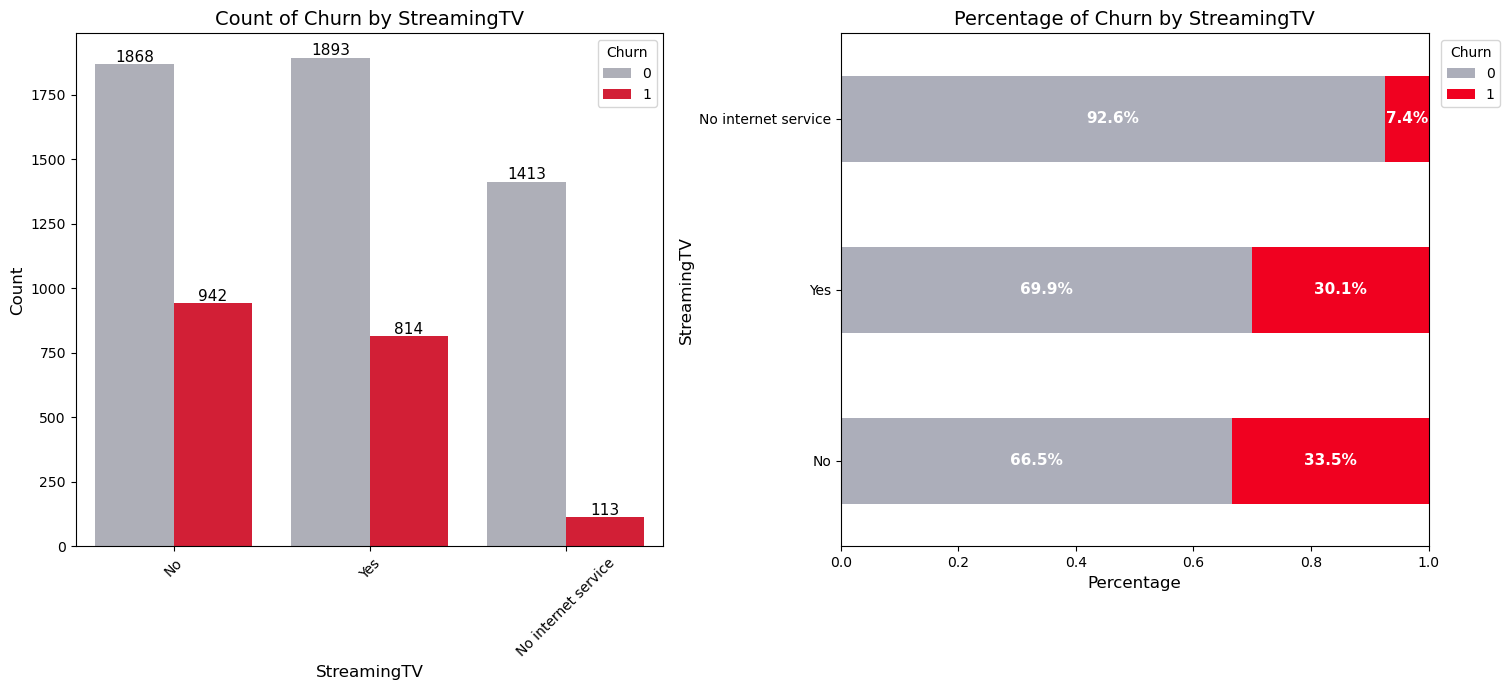

Categorical Variable: StreamingMovies


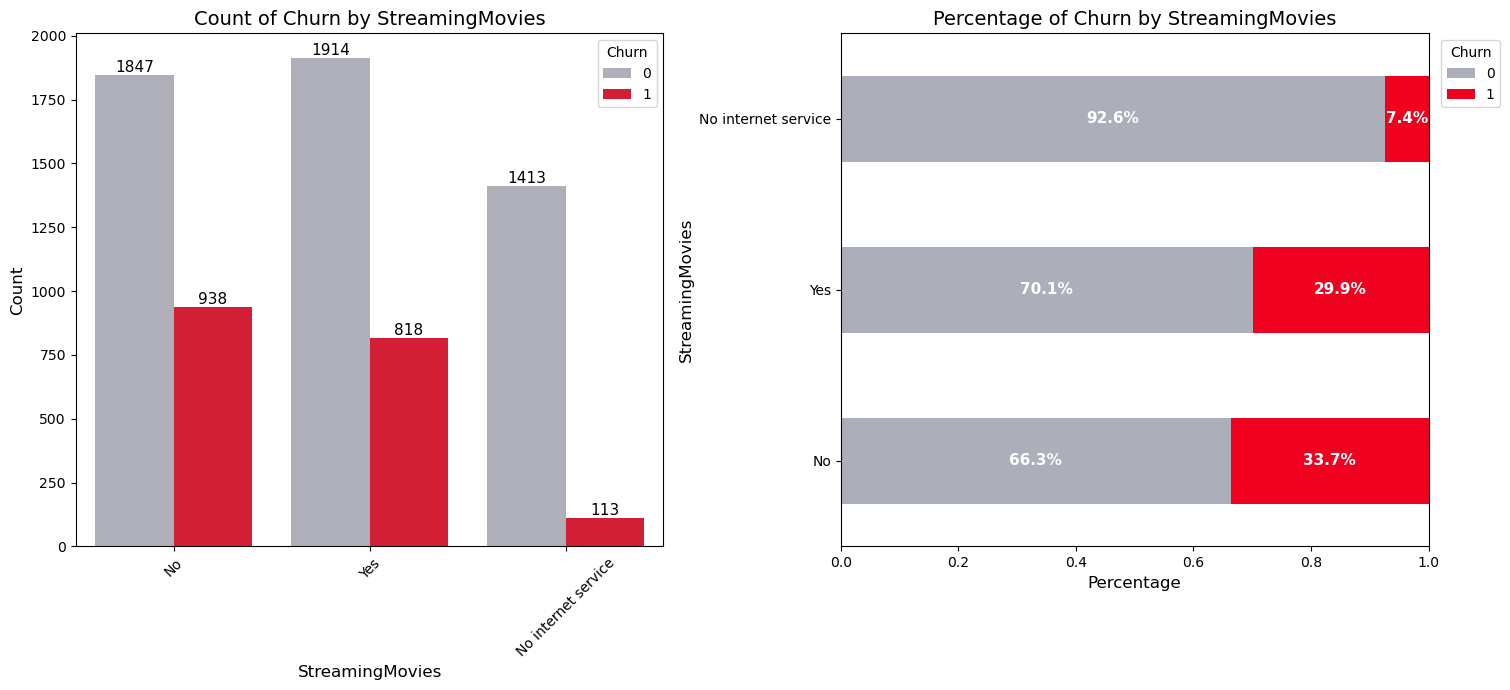

Categorical Variable: Contract


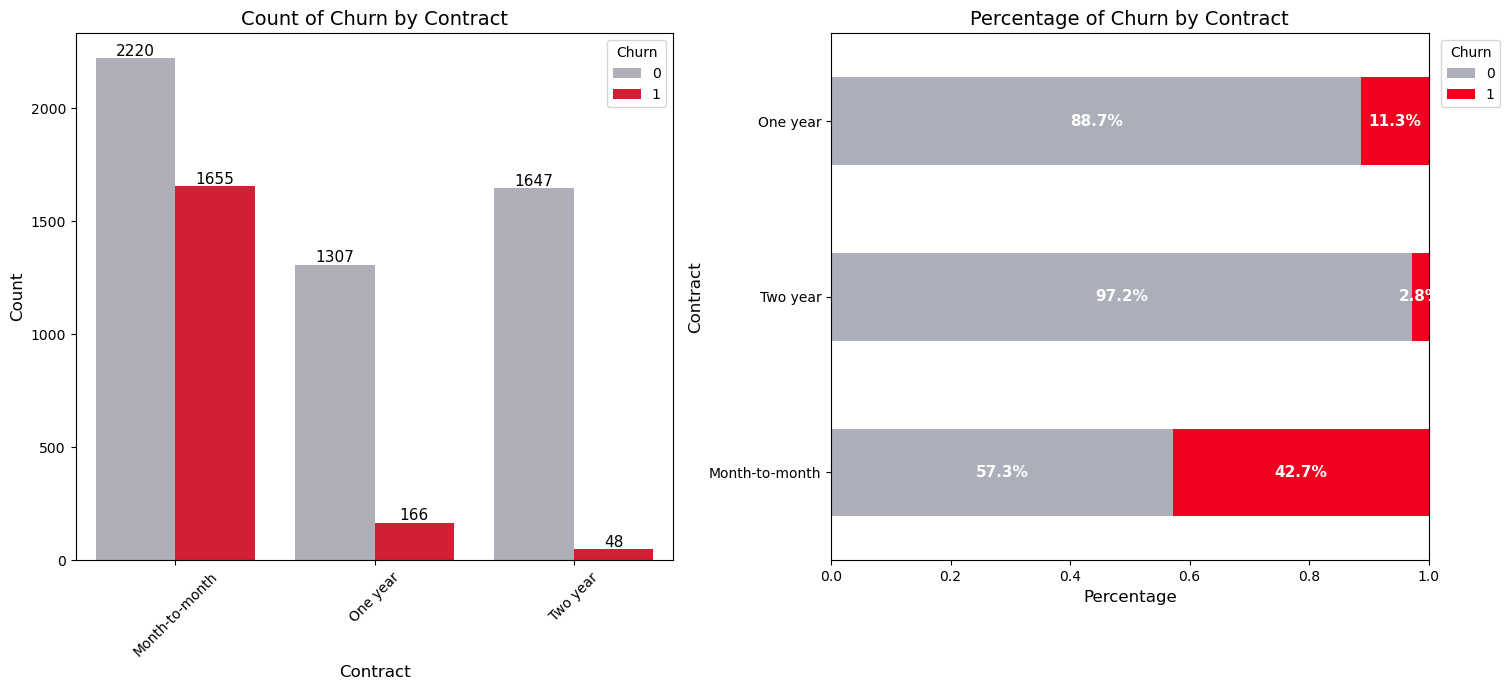

Categorical Variable: PaperlessBilling


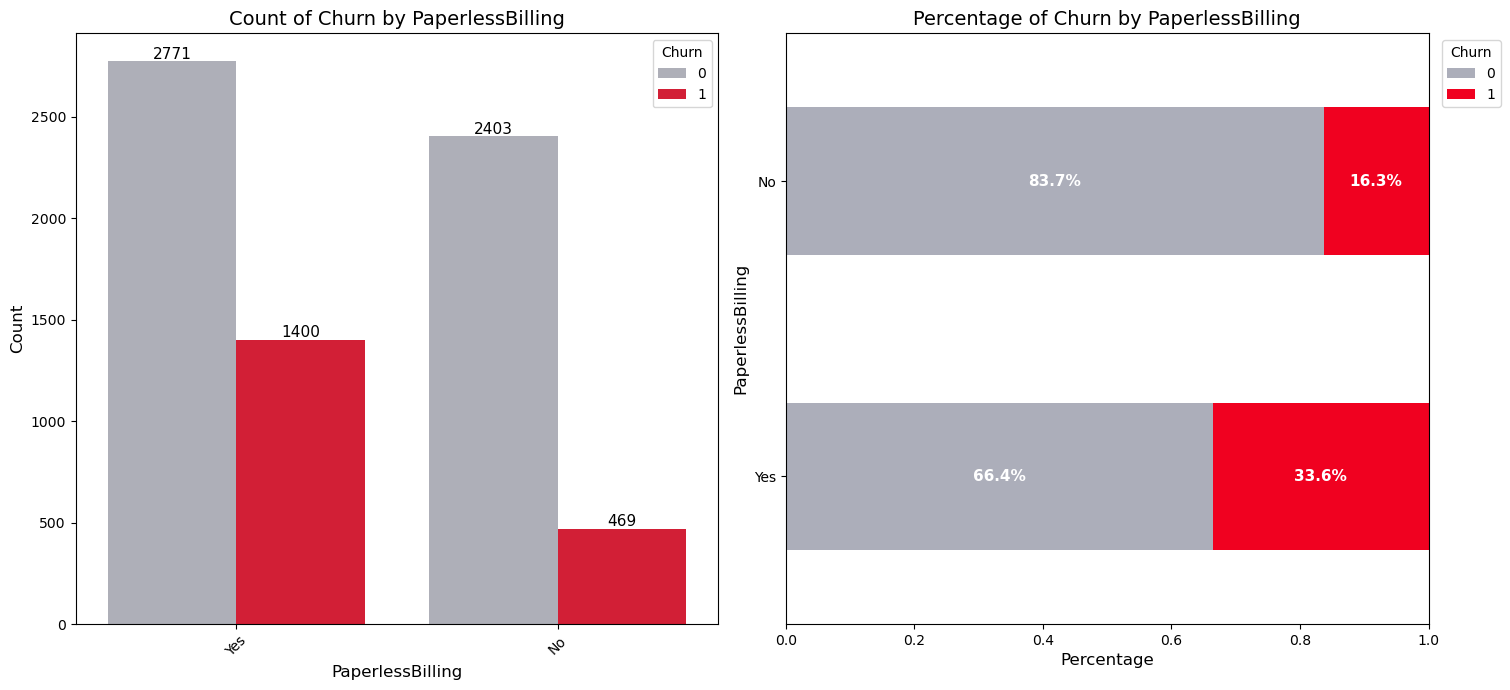

Categorical Variable: PaymentMethod


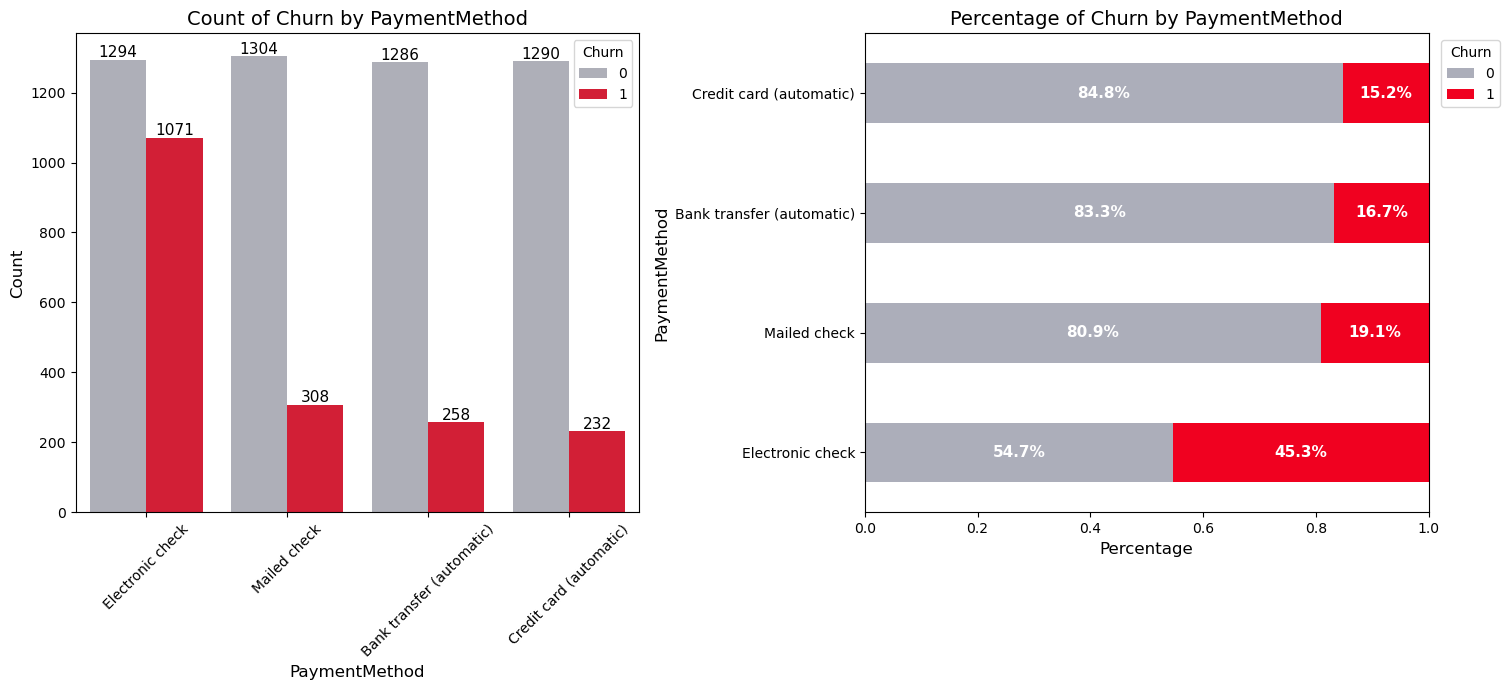

In [8]:
# Identify all categorical columns except the target variable 'Churn'
cat_cols = df.select_dtypes(include=['object']).columns

# Use the churn_palette for binary categorical variables (where target is 'Churn')
for col in cat_cols:
    print(f"Categorical Variable: {col}")
    plot_categorical_distribution(df, col, 'Churn')


- Customers without TechSupport churn at a much higher rate. This suggests that a poor support experience (or lack) is a major pain point. The same pattern holds for services like OnlineSecurity and DeviceProtection.

- The churn rate for customers on a Month-to-month contract is notably higher than for those on one or two-year contracts.

Correlation Analysis

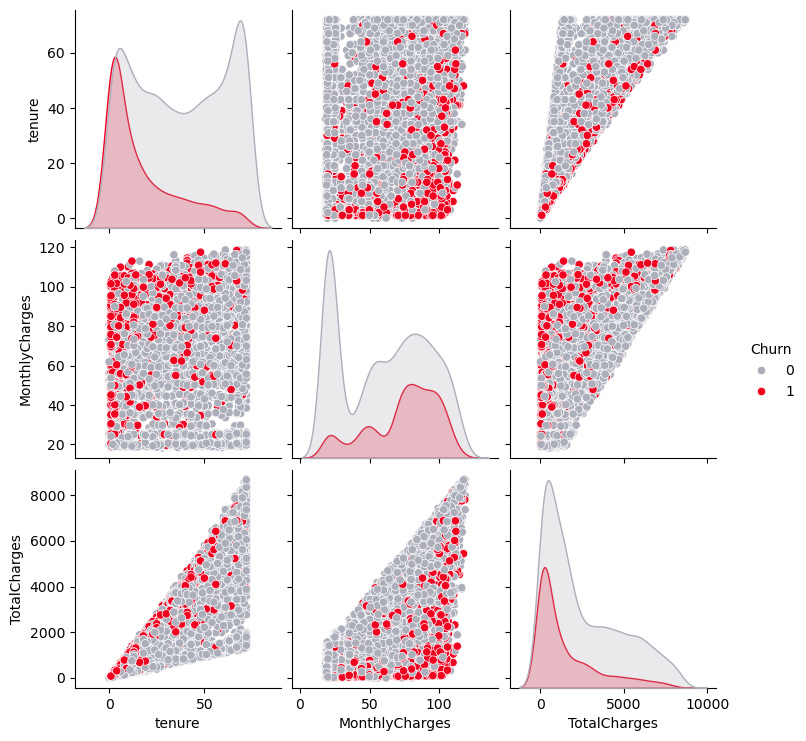

In [13]:
sns.pairplot(df.drop(['SeniorCitizen'], axis=1), hue='Churn', palette=churn_palette)

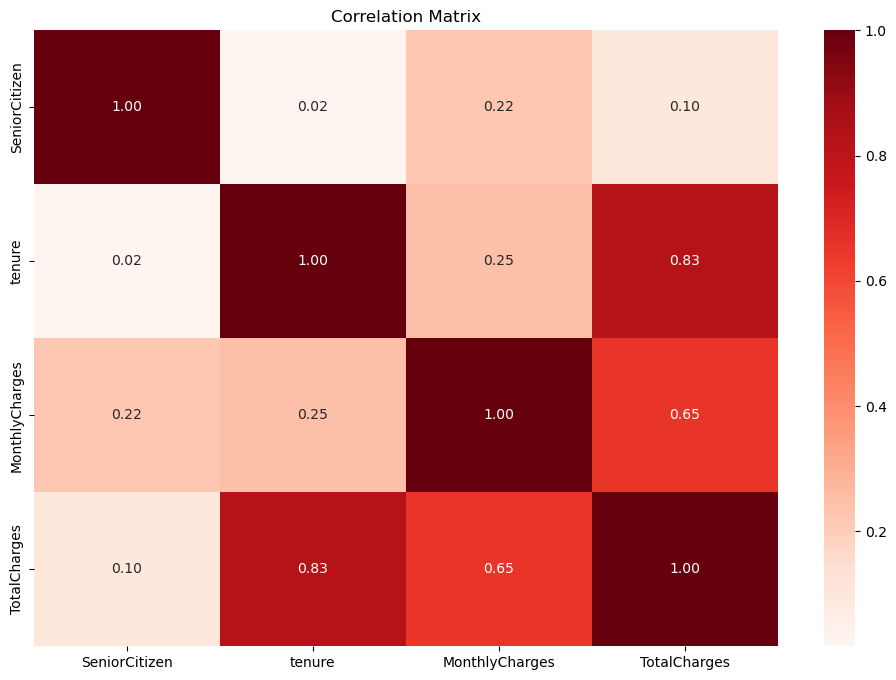

In [15]:
# plot correlation matrix
numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['Churn'])
corr_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds")
plt.title("Correlation Matrix")
plt.show()